In [19]:
import pandas as pd
from datetime import datetime, timedelta
from pandas import Index
import numpy as np

In [2]:
table=pd.read_csv("data/hour/airparif_20180501_20180728-PM25_h.csv",sep=';').drop(0,axis=0)
table=table.rename(mapper={'heure':'hour'},axis=1)
table['date time'] = list(map(lambda stringdate,
         dhour: str(datetime.strptime(stringdate,'%d/%m/%Y').replace(hour=int(dhour)-1)),
         table['date'],table['hour']))

In [3]:
# table.to_csv("output/pm25airparif.csv",index=False)

In [20]:
trend=pd.read_csv("data/hour/ggtrend 2018072120180728_parispollution_h.csv")
trend=trend.reset_index().drop(0,axis=0)
trend.columns=Index(['date time', 'air pollution'], dtype='object')
# because google trend gives us the local time. Our machine use EST time that is 6 hours behind the local time of paris
trend['date time']=list(map(lambda string: str(datetime.strptime(string,'%Y-%m-%dT%H')+timedelta(hours=6)),trend['date time']))

In [21]:
trend.to_csv("output/googletrend_airtopic.csv",index=False)

In [6]:
merged_t=table.merge(trend,left_on='date time',right_on='date time')

In [7]:
def str2int(mstr):
    if mstr == 'n/d':
        return None
    else: return int(mstr)

In [8]:
merged_t['PA04C']=list(map(lambda mstr: str2int(mstr),merged_t['PA04C']))

In [9]:
merged_t.PA04C =merged_t.PA04C.fillna(method='ffill')

In [10]:
merged_t['air pollution']=merged_t['air pollution'].astype(np.int8)

In [11]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

In [12]:
cross_correlation=merged_t[['air pollution','PA04C']]

In [13]:
new_cross=df_derived_by_shift(cross_correlation,lag=6)

In [14]:
new_cross = new_cross.dropna()

In [15]:
new_cross.head(10)

,air pollution,PA04C,air pollution_1,air pollution_2,air pollution_3,air pollution_4,air pollution_5,air pollution_6,PA04C_1,PA04C_2,PA04C_3,PA04C_4,PA04C_5,PA04C_6
6,27,15.0,27.0,26.0,19.0,22.0,22.0,20.0,14.0,15.0,18.0,18.0,15.0,15.0
7,6,14.0,27.0,27.0,26.0,19.0,22.0,22.0,15.0,14.0,15.0,18.0,18.0,15.0
8,21,14.0,6.0,27.0,27.0,26.0,19.0,22.0,14.0,15.0,14.0,15.0,18.0,18.0
9,33,14.0,21.0,6.0,27.0,27.0,26.0,19.0,14.0,14.0,15.0,14.0,15.0,18.0
10,20,14.0,33.0,21.0,6.0,27.0,27.0,26.0,14.0,14.0,14.0,15.0,14.0,15.0
11,0,12.0,20.0,33.0,21.0,6.0,27.0,27.0,14.0,14.0,14.0,14.0,15.0,14.0
12,19,12.0,0.0,20.0,33.0,21.0,6.0,27.0,12.0,14.0,14.0,14.0,14.0,15.0
13,51,14.0,19.0,0.0,20.0,33.0,21.0,6.0,12.0,12.0,14.0,14.0,14.0,14.0
14,38,13.0,51.0,19.0,0.0,20.0,33.0,21.0,14.0,12.0,12.0,14.0,14.0,14.0
15,35,15.0,38.0,51.0,19.0,0.0,20.0,33.0,13.0,14.0,12.0,12.0,14.0,14.0


In [16]:
new_cross.corr()

,air pollution,PA04C,air pollution_1,air pollution_2,air pollution_3,air pollution_4,air pollution_5,air pollution_6,PA04C_1,PA04C_2,PA04C_3,PA04C_4,PA04C_5,PA04C_6
air pollution,1.000000,0.403458,0.340053,0.375182,0.292792,0.209723,0.127176,0.092661,0.394744,0.430346,0.433064,0.378681,0.345887,0.363216
PA04C,0.403458,1.000000,0.405000,0.366617,0.348062,0.313236,0.282530,0.259754,0.929047,0.819925,0.724216,0.653665,0.602507,0.569539
air pollution_1,0.340053,0.405000,1.000000,0.330642,0.368293,0.283007,0.201057,0.116580,0.396913,0.389584,0.424659,0.426698,0.370994,0.338379
air pollution_2,0.375182,0.366617,0.330642,1.000000,0.319408,0.353580,0.270478,0.185309,0.395019,0.389642,0.380199,0.414297,0.415111,0.359521
air pollution_3,0.292792,0.348062,0.368293,0.319408,1.000000,0.309776,0.346763,0.262317,0.360432,0.390371,0.382014,0.371516,0.407074,0.408618
air pollution_4,0.209723,0.313236,0.283007,0.353580,0.309776,1.000000,0.299174,0.335624,0.338598,0.353590,0.381086,0.371075,0.360217,0.397555
air pollution_5,0.127176,0.282530,0.201057,0.270478,0.346763,0.299174,1.000000,0.290355,0.305725,0.333000,0.345627,0.372398,0.362633,0.352449
air pollution_6,0.092661,0.259754,0.116580,0.185309,0.262317,0.335624,0.290355,1.000000,0.274094,0.299437,0.323770,0.335280,0.363110,0.354187
PA04C_1,0.394744,0.929047,0.396913,0.395019,0.360432,0.338598,0.305725,0.274094,1.000000,0.928675,0.816922,0.719785,0.649326,0.597947
PA04C_2,0.430346,0.819925,0.389584,0.389642,0.390371,0.353590,0.333000,0.299437,0.928675,1.000000,0.927485,0.814832,0.717606,0.646463


In [17]:
df_new =new_cross

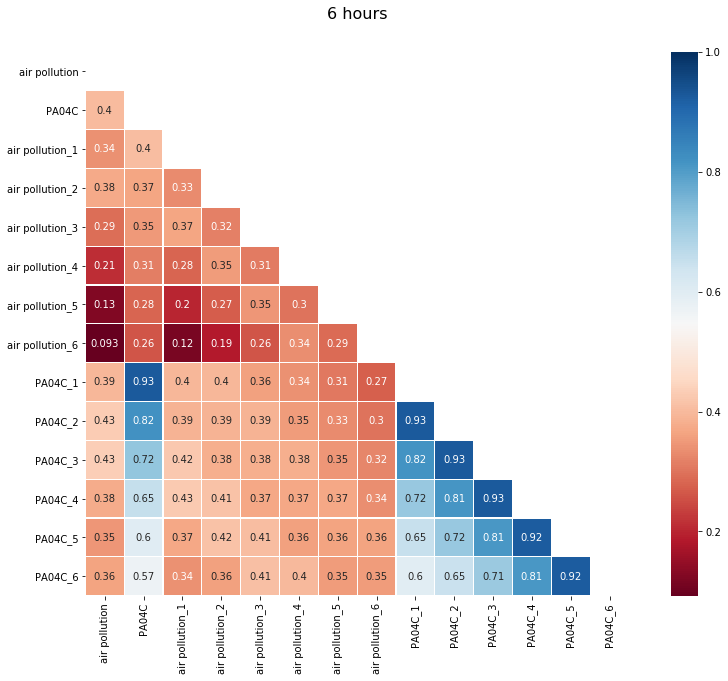

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'6 hours', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)